In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 8
commitnumber = a06b618
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0, -1, 0]
ng_refs = [3, 2, 3]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 294
vmax = 1900
vmin = 1380
w_diffuse = [(1.66, 1.66, 1.66), (1.66, 1.66), (1.66, 1.66, 1.66)]
wgt = [(0.55, 0.55, 0.85), (0.85, 0.85), (0, 0.3, 0.55)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

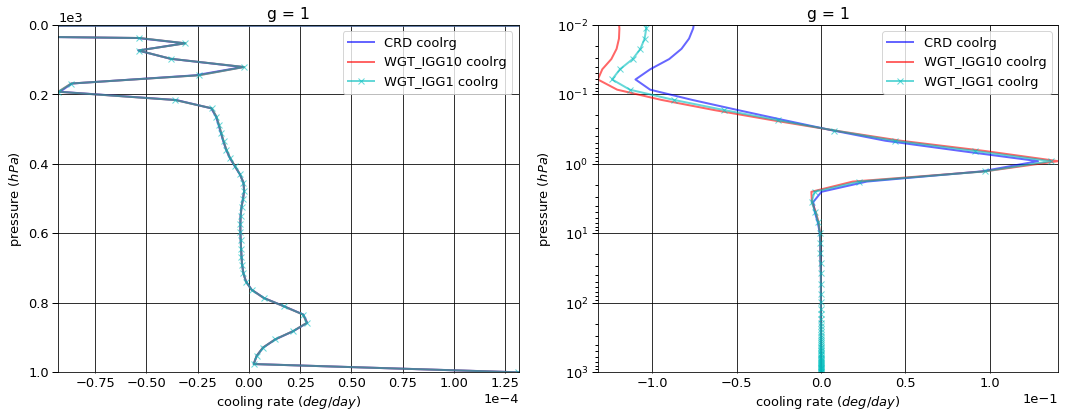

# Figure: cooling rate g-group 2

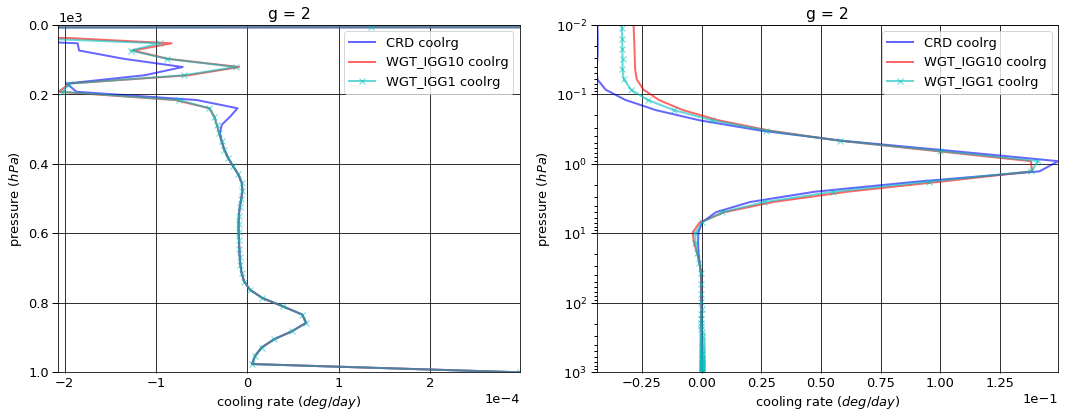

# Figure: cooling rate g-group 3

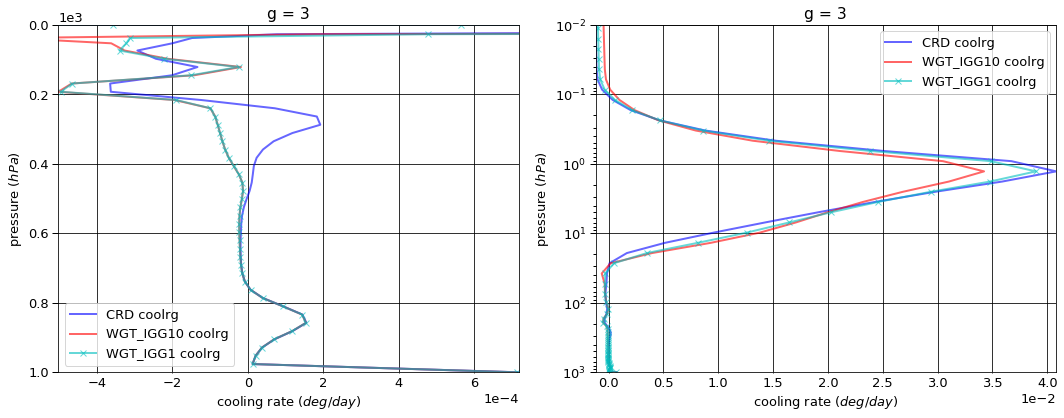

# Figure: cooling rate g-group 4

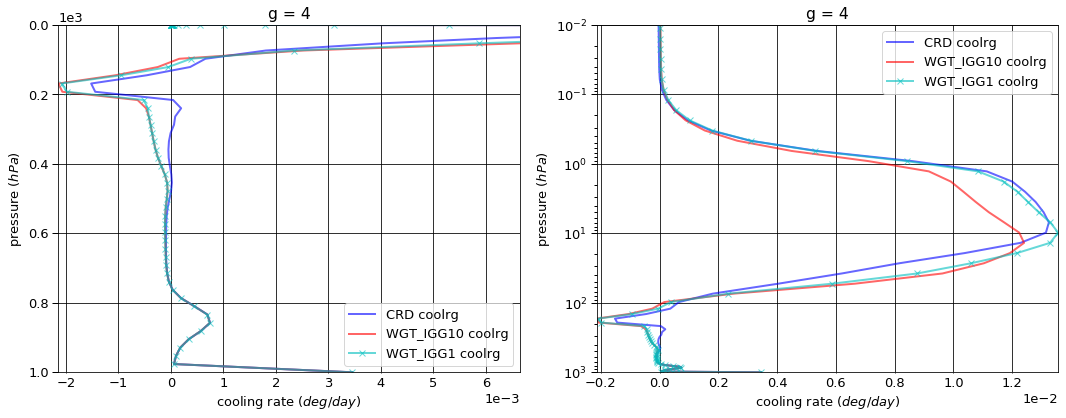

# Figure: cooling rate g-group 5

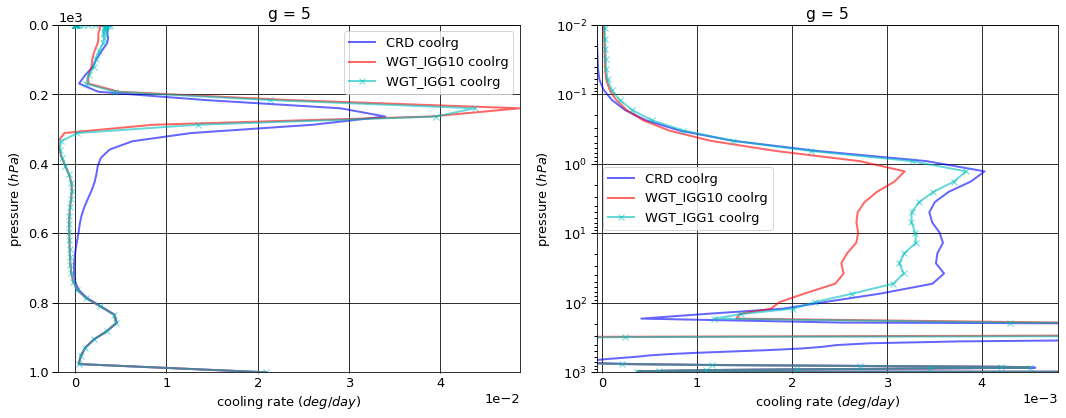

# Figure: cooling rate g-group 6

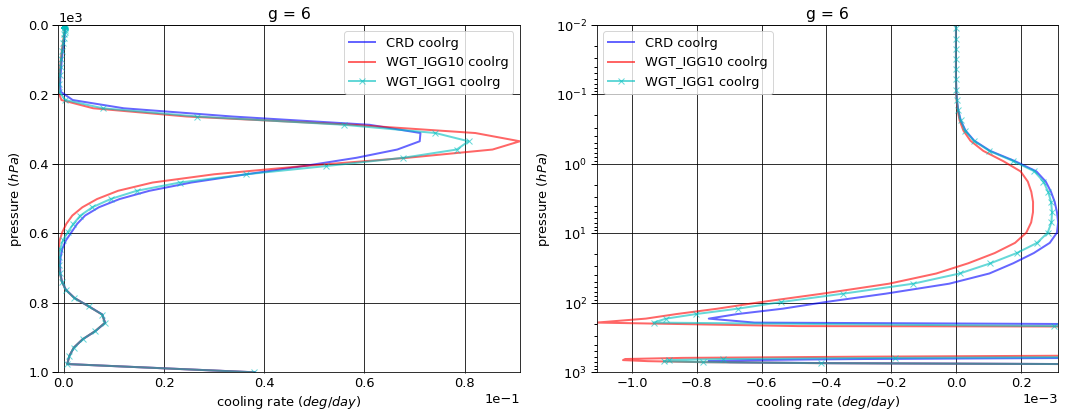

# Figure: cooling rate g-group 7

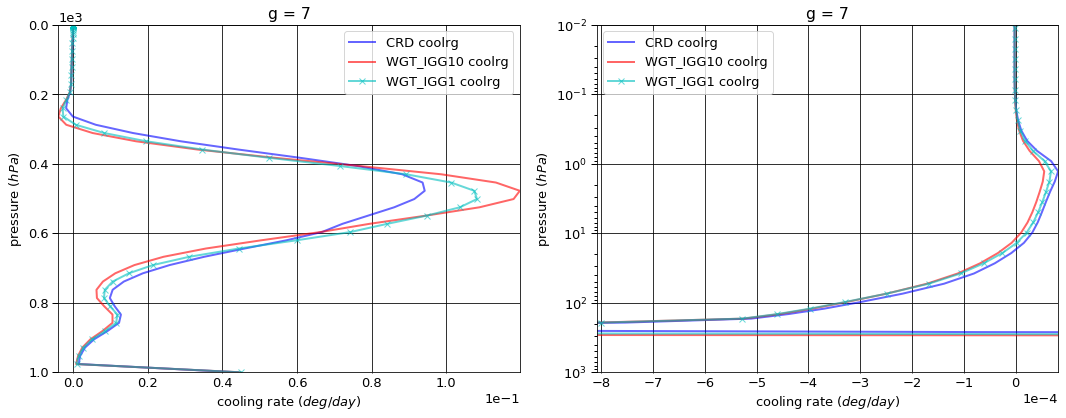

# Figure: cooling rate g-group 8

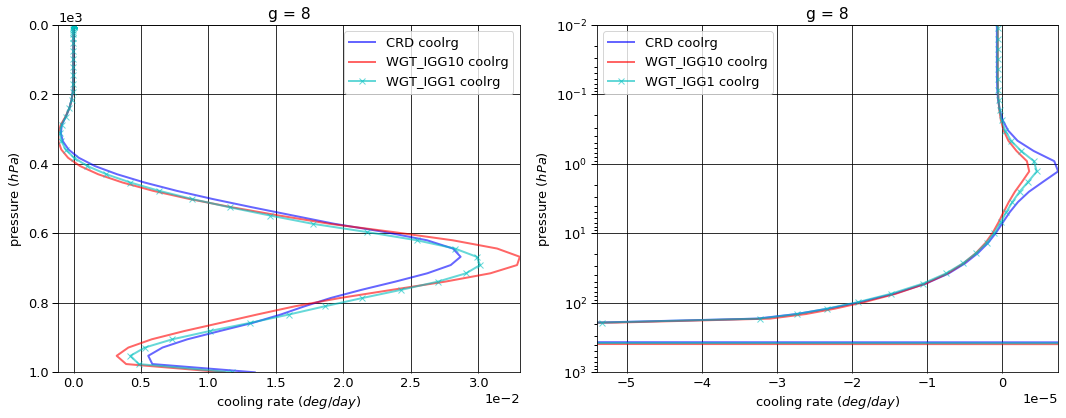

# Figure: cooling rate g-group total

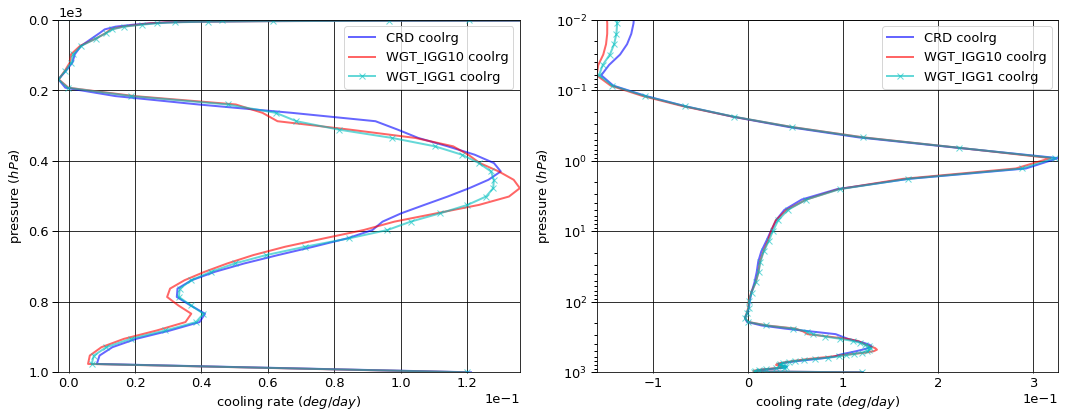

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009038   0.000000 -0.009038
  1013.0   76     -0.034574   0.034204 -0.000370
2 0.0      1      -0.026240   0.000000 -0.026240
  1013.0   76     -0.078580   0.077739 -0.000841
3 0.0      1      -0.031238   0.000000 -0.031238
  1013.0   76     -0.188777   0.186752 -0.002025
4 0.0      1      -0.083502   0.000000 -0.083502
  1013.0   76     -0.909609   0.899871 -0.009738
5 0.0      1      -0.632001   0.000000 -0.632001
  1013.0   76     -5.496186   5.437373 -0.058813
6 0.0      1      -1.795379   0.000000 -1.795379
  1013.0   76    -10.025001   9.917460 -0.107541
7 0.0      1      -3.550377   0.000000 -3.550377
  1013.0   76    -11.606732  11.482066 -0.124665
8 0.0      1      -1.164275   0.000000 -1.164275
  1013.0   76     -2.390157   2.336936 -0.053221


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.008574   0.000000 -0.008574
  1013.0   76     -0.034459   0.034090 -0.000369
2 0.0      1      -0.028185   0.000000 -0.028185
  1013.0   76     -0.078543   0.077702 -0.000841
3 0.0      1      -0.031038   0.000000 -0.031038
  1013.0   76     -0.187919   0.185907 -0.002012
4 0.0      1      -0.078713   0.000000 -0.078713
  1013.0   76     -0.907500   0.897782 -0.009718
5 0.0      1      -0.526453   0.000000 -0.526453
  1013.0   76     -5.494937   5.436095 -0.058842
6 0.0      1      -1.793374   0.000000 -1.793374
  1013.0   76     -9.980273   9.873400 -0.106873
7 0.0      1      -3.566391   0.000000 -3.566391
  1013.0   76    -11.782356  11.656155 -0.126200
8 0.0      1      -1.133137   0.000000 -1.133137
  1013.0   76     -2.263629   2.227025 -0.036604


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.008750   0.000000 -0.008750
  1013.0   76     -0.034459   0.034090 -0.000369
2 0.0      1      -0.027418   0.000000 -0.027418
  1013.0   76     -0.078543   0.077702 -0.000841
3 0.0      1      -0.031480   0.000000 -0.031480
  1013.0   76     -0.187919   0.185907 -0.002012
4 0.0      1      -0.079835   0.000000 -0.079835
  1013.0   76     -0.907500   0.897782 -0.009718
5 0.0      1      -0.532800   0.000000 -0.532800
  1013.0   76     -5.494937   5.436095 -0.058842
6 0.0      1      -1.814592   0.000000 -1.814592
  1013.0   76     -9.980273   9.873400 -0.106873
7 0.0      1      -3.609417   0.000000 -3.609417
  1013.0   76    -11.782356  11.655916 -0.126440
8 0.0      1      -1.141975   0.000000 -1.141975
  1013.0   76     -2.263629   2.222832 -0.040797


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000464  0.000000  4.639574e-04
  1013.0   76     0.000115 -0.000114  1.350710e-06
2 0.0      1     -0.001945  0.000000 -1.944748e-03
  1013.0   76     0.000037 -0.000038 -4.811000e-08
3 0.0      1      0.000199  0.000000  1.992820e-04
  1013.0   76     0.000858 -0.000845  1.296980e-05
4 0.0      1      0.004789  0.000000  4.789218e-03
  1013.0   76     0.002109 -0.002088  2.035980e-05
5 0.0      1      0.105548  0.000000  1.055475e-01
  1013.0   76     0.001249 -0.001278 -2.879700e-05
6 0.0      1      0.002005  0.000000  2.004500e-03
  1013.0   76     0.044728 -0.044060  6.682800e-04
7 0.0      1     -0.016014  0.000000 -1.601360e-02
  1013.0   76    -0.175624  0.174089 -1.535150e-03
8 0.0      1      0.031137  0.000000  3.113740e-02
  1013.0   76     0.126528 -0.109911  1.661693e-02


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1      0.000288  0.000000  2.875142e-04
  1013.0   76     0.000115 -0.000114  1.350710e-06
2 0.0      1     -0.001178  0.000000 -1.177682e-03
  1013.0   76     0.000037 -0.000038 -4.811000e-08
3 0.0      1     -0.000243  0.000000 -2.426950e-04
  1013.0   76     0.000858 -0.000845  1.296980e-05
4 0.0      1      0.003667  0.000000  3.666906e-03
  1013.0   76     0.002109 -0.002088  2.035980e-05
5 0.0      1      0.099201  0.000000  9.920121e-02
  1013.0   76     0.001249 -0.001278 -2.879700e-05
6 0.0      1     -0.019213  0.000000 -1.921330e-02
  1013.0   76     0.044728 -0.044060  6.682800e-04
7 0.0      1     -0.059040  0.000000 -5.903990e-02
  1013.0   76    -0.175624  0.173850 -1.774400e-03
8 0.0      1      0.022300  0.000000  2.229990e-02
  1013.0   76     0.126528 -0.114104  1.242386e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.731315e-02
  1001.112500 75     1.314864e-04
2 0.000312    1     -4.532029e-02
  1001.112500 75     2.985825e-04
3 0.000312    1     -1.334936e-03
  1001.112500 75     7.189885e-04
4 0.000312    1     -5.381745e-05
  1001.112500 75     3.457445e-03
5 0.000312    1     -8.181423e-05
  1001.112500 75     2.087430e-02
6 0.000312    1     -5.639268e-07
  1001.112500 75     3.817795e-02
7 0.000312    1     -2.054673e-06
  1001.112500 75     4.414074e-02
8 0.000312    1     -7.465258e-07
  1001.112500 75     1.344245e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.323780e-01
  1001.112500 75     1.309941e-04
2 0.000312    1     -2.961398e-02
  1001.112500 75     2.985812e-04
3 0.000312    1     -6.263648e-04
  1001.112500 75     7.143754e-04
4 0.000312    1      7.368822e-06
  1001.112500 75     3.449862e-03
5 0.000312    1     -6.694094e-07
  1001.112500 75     2.088900e-02
6 0.000312    1     -5.278333e-07
  1001.112500 75     3.794000e-02
7 0.000312    1     -1.758738e-06
  1001.112500 75     4.480713e-02
8 0.000312    1     -6.044994e-07
  1001.112500 75     1.121235e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.167036e-01
  1001.112500 75     1.309941e-04
2 0.000312    1     -3.475271e-02
  1001.112500 75     2.985812e-04
3 0.000312    1     -1.138426e-03
  1001.112500 75     7.143754e-04
4 0.000312    1     -5.138296e-06
  1001.112500 75     3.449862e-03
5 0.000312    1      4.184308e-06
  1001.112500 75     2.088900e-02
6 0.000312    1     -5.197909e-07
  1001.112500 75     3.794000e-02
7 0.000312    1     -1.820880e-06
  1001.112500 75     4.489862e-02
8 0.000312    1     -6.394851e-07
  1001.112500 75     1.172786e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.506486e-02
  1001.112500 75    -4.922700e-07
2 0.000312    1      1.570631e-02
  1001.112500 75    -1.370000e-09
3 0.000312    1      7.085715e-04
  1001.112500 75    -4.613100e-06
4 0.000312    1      6.118627e-05
  1001.112500 75    -7.583700e-06
5 0.000312    1      8.114482e-05
  1001.112500 75     1.470000e-05
6 0.000312    1      3.609350e-08
  1001.112500 75    -2.379570e-04
7 0.000312    1      2.959349e-07
  1001.112500 75     6.663890e-04
8 0.000312    1      1.420264e-07
  1001.112500 75    -2.230102e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.939041e-02
  1001.112500 75    -4.922700e-07
2 0.000312    1      1.056758e-02
  1001.112500 75    -1.370000e-09
3 0.000312    1      1.965107e-04
  1001.112500 75    -4.613100e-06
4 0.000312    1      4.867915e-05
  1001.112500 75    -7.583700e-06
5 0.000312    1      8.599854e-05
  1001.112500 75     1.470000e-05
6 0.000312    1      4.413596e-08
  1001.112500 75    -2.379570e-04
7 0.000312    1      2.337927e-07
  1001.112500 75     7.578810e-04
8 0.000312    1      1.070407e-07
  1001.112500 75    -1.714597e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.292049,0.0000,-7.292049
1013.0,76,-30.729616,30.3724,-0.357216



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.165865,0.000000,-7.165865
1013.0,76,-30.729617,30.388156,-0.341460



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.246267,0.000000,-7.246267
1013.0,76,-30.729617,30.383724,-0.345892



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.261835e-01,0.000000,0.126184
1013.0,76,-2.190000e-07,0.015756,0.015756



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,4.578195e-02,0.000000,0.045782
1013.0,76,-2.190000e-07,0.011324,0.011324


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.134107
1001.112500,75,0.121242



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.162615
1001.112500,75,0.119442



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.152599
1001.112500,75,0.120049



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.028507
1001.112500,75,-0.001800



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.018491
1001.112500,75,-0.001193


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001075,0.001121
2,0.002500,0.002556
3,0.006004,0.006115
4,0.028350,0.029532
5,0.170713,0.178816
6,0.317971,0.324777
7,0.364756,0.383420
8,0.108631,0.073663


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.712719e-18
2,3.036482e-19
3,1.956454e-20
4,6.326694e-21
5,2.056007e-22
6,1.045323e-21
7,1.065660e-22
8,1.086393e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.712719e-18,NaN,0.001075,0.001121,0.001075,0.001121,1.0
2,3.036482e-19,0.064432,0.002500,0.002556,0.003575,0.003677,1.0
3,1.956454e-20,0.064432,0.006004,0.006115,0.009579,0.009793,1.0
4,6.326694e-21,0.323376,0.028350,0.029532,0.037929,0.039324,10.0
5,2.056007e-22,0.032497,0.170713,0.178816,0.208642,0.218140,10.0
6,1.045323e-21,5.084237,0.317971,0.324777,0.526613,0.542917,500.0
7,1.065660e-22,0.101946,0.364756,0.383420,0.891369,0.926337,500.0
8,1.086393e-23,0.101946,0.108631,0.073663,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
